# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [17]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

from dyn_cond_fig_functions import *

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

In [5]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min=40

### Style settings

In [7]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

In [10]:
# Functions
def free_energy_droplet(Ld, mu, alpha, gamma):
    return -mu*alpha*Ld + gamma * 4. * np.pi * np.power(3.*alpha*Ld/(4*np.pi), 2./3.)

def free_energy_polymer(Ld, Ltot, Lsep, kappa):
    eps = Ltot - Ld
    return .25* kappa* ((eps /(1.-(Lsep/eps))) - Lsep + 2.*((Lsep*Lsep)/eps) - eps)

def tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return free_energy_droplet(Ld, mu, alpha, gamma) + free_energy_polymer(Ld, Ltot, Lsep, kappa)

def free_energy_deriv(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return -mu*alpha + (1./12.) * (8.*np.power(6.*alpha, 2./3.)*gamma*np.power(np.pi/Ld, 1./3.) + 3.*kappa*(Lsep**2)*(2./np.power(Ld-Ltot, 2.) + 1./np.power(Lsep + Ld - Ltot, 2.)))

def length_prob_unnorm(Ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
    # return tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)

def partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=1./.0041):
    return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))

def free_energy_contimuous_deriv_two_blobs(
    ld, L, Ltot=1.0, mu=1.0, alpha=1.0, gamma=1.0, kappa=1.0
):
    return (1.0 / 6.0) * (
        -12 * alpha * mu
        + (3 * kappa * L**2)
        * (2 * L**2 - 4 * L * (Ltot - 2 * ld) + 3 * (Ltot - 2 * ld) ** 2)
        / ((Ltot - 2 * ld) ** 2 * (L - Ltot + 2 * ld) ** 2)
        + (8 * np.power(6, 2.0 / 3.0) * alpha * gamma * np.cbrt(np.pi / alpha * ld))
    )


def calc_max_beads_in_two_condensates(
    Lsep=1.0, Ltot=1.0, mu=1.0, alpha=1.0, gamma=1.0, kappa=1.0, **kwargs
):
    epsilon = 0.000001
    ld_lower_bound = epsilon  # Can't be zero,
    ld_upper_bound = (Ltot - (Lsep+ epsilon)) * .5 
    while (
        free_energy_contimuous_deriv_two_blobs(
            ld_lower_bound, Lsep, Ltot, mu, alpha, gamma, kappa
        )
        > 0
    ):
        ld_lower_bound += 0.1

    if (
        ld_lower_bound > ld_upper_bound
        or free_energy_contimuous_deriv_two_blobs(
            ld_upper_bound, Lsep, Ltot, mu, alpha, gamma, kappa
        )
        < 0
    ):
        # No max was found, condensates would not exist
        print("No max found with end separation", Lsep)
        return 0

    result = root_scalar(
        free_energy_contimuous_deriv_two_blobs,
        method="brentq",
        args=(Lsep, Ltot, mu, alpha, gamma, kappa),
        bracket=[ld_lower_bound, ld_upper_bound],
    )
    return result.root


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


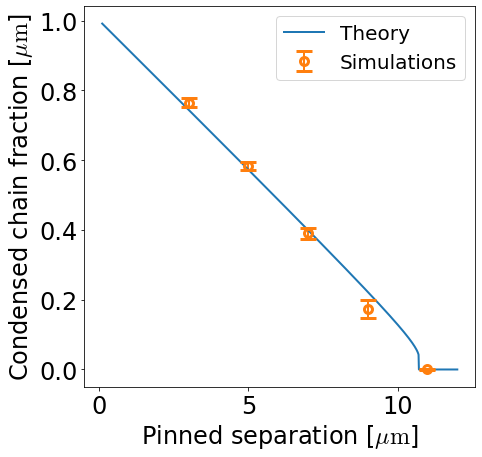

In [11]:
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um
# alpha = .05 # Condensate packing factor um^2 
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4.1 # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))


# Get theoretical results
lsep_arr = np.linspace(.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size) 
for i, lsep in enumerate(lsep_arr):
    bound = .1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += .5
    if bound > Ltot-(lsep*1.0000001):
        ld_max_prob[i] = 0.
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(free_energy_deriv, method='brentq', bracket=[bound, Ltot-(lsep*1.0000001)], args=(Ltot, lsep, mu, alpha, gamma, kappa))
    ld_max_prob[i] = result.root
_ = axarr.plot(lsep_arr, ld_max_prob/Ltot, label='Theory')
_ = axarr.set_xlabel(r'Pinned separation [$\mu {\rm m}$]')
_ = axarr.set_ylabel(r'Condensed chain fraction [$\mu {\rm m}$]')

with h5py.File('Figure2/fig2_pin_ke_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=8, markerfacecolor='none', capsize=8, label='Simulations')


_ = axarr.legend()


In [22]:
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um
# alpha = .05 # Condensate packing factor um^2 
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4.1 # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16 # Total length of the polymer um
L = 9.0 # Separation of chain ends

beta = 1./.0041


calc_max_length_in_single_condensate(L, Ltot, mu, alpha, gamma, kappa)/.01




484.2350974365514

No max found with end separation 11.976176176176176
No max found with end separation 11.98808808808809
No max found with end separation 12.0


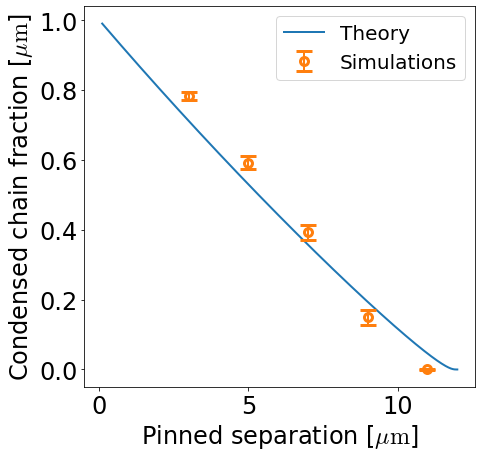

In [35]:
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um
# alpha = .05 # Condensate packing factor um^2 
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4.1 # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(7, 7))


# Get theoretical results
lsep_arr = np.linspace(.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size) 
for i, lsep in enumerate(lsep_arr):
    ld_max_prob[i] = calc_max_beads_in_two_condensates(Lsep=lsep, Ltot=Ltot, mu=mu, alpha=alpha, gamma=gamma, kappa=kappa)
_ = axarr.plot(lsep_arr, 2.*ld_max_prob/Ltot, label='Theory')
_ = axarr.set_xlabel(r'Pinned separation [$\mu {\rm m}$]')
_ = axarr.set_ylabel(r'Condensed chain fraction [$\mu {\rm m}$]')

with h5py.File('Figure2/fig2_pin_ke_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 100:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=8, markerfacecolor='none', capsize=8, label='Simulations')


_ = axarr.legend()


/tmp/ipykernel_2692965/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2692965/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2692965/2359384887.py:14: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
/tmp/ipykernel_2692965/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2692965/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2692965/2359384887.py:19: Runtim

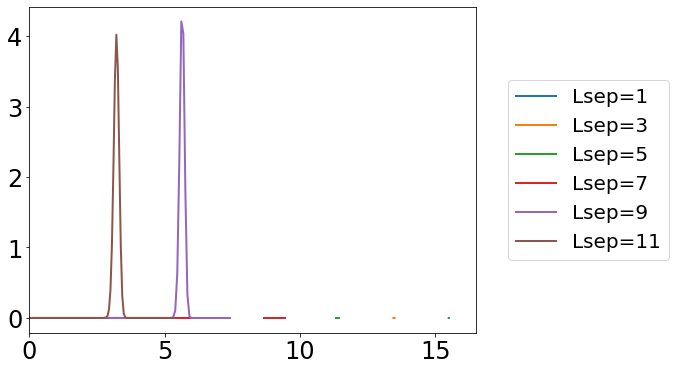

In [12]:
# Parameters (from Renger et al.)
mu = 11. # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16.5 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))

Lsep = 1 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 3 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 5 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 7 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 9 
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 11
ld = np.linspace(0, Ltot-(Lsep*1.01), 100)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
_ = axarr.set_xlim(0, 16.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



# length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa),


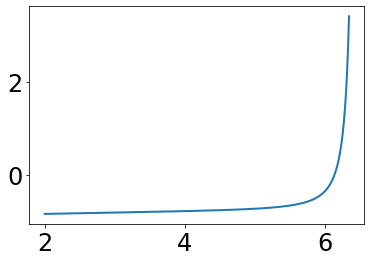

In [19]:
mu = 10.1 # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16 # Total length of the polymer um
Lsep = 3

ld = np.linspace(2, (Ltot-(Lsep*1.1))*.5, 1000)

plt.plot(ld, free_energy_contimuous_deriv_two_blobs(ld, Lsep, Ltot, mu, alpha, gamma, kappa))

-0.49474820737451375

1.5667388778001416

12.887909690573421


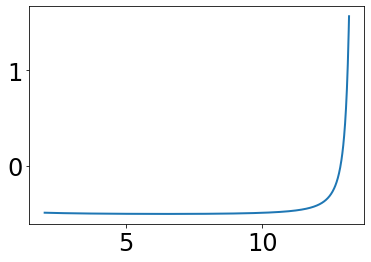

In [16]:
from scipy.optimize import root_scalar
Lsep = 3
ld = np.linspace(2, Ltot-(Lsep*1.1), 1000)
free_energy_deriv(ld[0], Ltot, Lsep, mu, alpha, gamma, kappa)
free_energy_deriv(ld[-1], Ltot, Lsep, mu, alpha, gamma, kappa)
plt.plot(ld, free_energy_deriv(ld, Ltot, Lsep, mu, alpha, gamma, kappa))
# # Find a root of the function
result = root_scalar(free_energy_deriv, method='brentq', bracket=[0.1, Ltot-(Lsep*1.00001)], args=(Ltot, Lsep, mu, alpha, gamma, kappa))

# # Print the root
print(result.root)

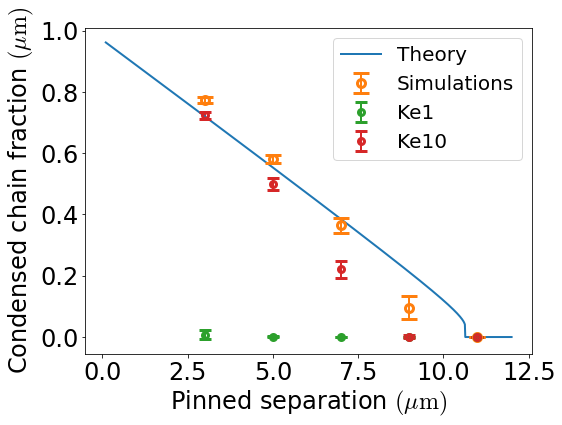

In [9]:
from scipy.optimize import root_scalar
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um
# alpha = .05 # Condensate packing factor um^2 
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4. # Free energy per volume pN/um
alpha = .05 # Condensate packing factor um^2 
gamma = .15 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16. # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))


# Get theoretical results
lsep_arr = np.linspace(.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size) 
for i, lsep in enumerate(lsep_arr):
    bound = .1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += .5
    if bound > Ltot-(lsep*1.0000001):
        ld_max_prob[i] = 0.
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(free_energy_deriv, method='brentq', bracket=[bound, Ltot-(lsep*1.0000001)], args=(Ltot, lsep, mu, alpha, gamma, kappa))
    ld_max_prob[i] = result.root
_ = axarr.plot(lsep_arr, ld_max_prob/16.5, label='Theory')
_ = axarr.set_xlabel(r'Pinned separation $(\mu {\rm m})$')
_ = axarr.set_ylabel(r'Condensed chain fraction $(\mu {\rm m})$')

with h5py.File('Figure2/fig2b_pin_ke_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=8, markerfacecolor='none', capsize=8, label='Simulations')

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 1:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='Ke1')

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != 'time':
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs['Ke'], h5_data.attrs['pin_dist']
            if Ke == 10:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size//2:, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size//2:, 1].mean()]

    _ = axarr.errorbar(pin_dist_arr, np.array(beads_num_arr)/1600., yerr=np.array(beads_std_arr)/1600., fmt='o', markeredgewidth=3, markersize=6, markerfacecolor='none', capsize=6, label='Ke10')

# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.legend()


# # Print the root

2.84702446440215e-68


/tmp/ipykernel_2692965/1772400338.py:20: RuntimeWarning: overflow encountered in exp
  return quad(lambda Ld: np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)), 0, Ltot-(Lsep*1.001))
/tmp/ipykernel_2692965/1772400338.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(-beta*tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
/tmp/ipykernel_2692965/804397414.py:14: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')


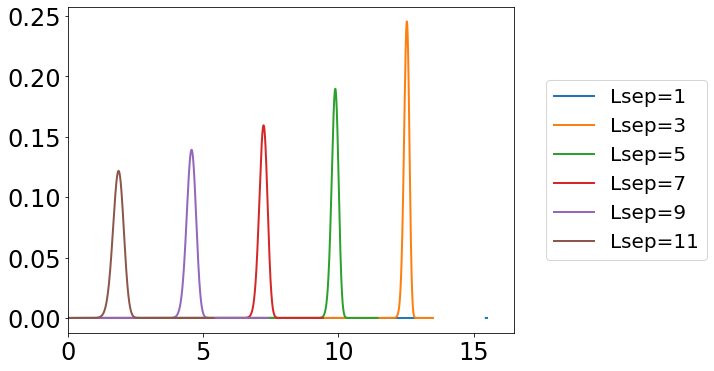

In [10]:
# Parameters (from Renger et al.)
mu = 2.6 # Free energy per volume pN/um
alpha = .09 # Condensate packing factor um^2 
gamma = .04 # Surface tension pN/um
kappa = .0822 # Filament flexibility pN
Ltot = 16.5 # Total length of the polymer um

beta = 1./.0041
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))

Lsep = 1 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 3 
ld = np.linspace(0, Ltot-(Lsep*1.001), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 5 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 7 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 9 
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0] * Ltot
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')

Lsep = 11
ld = np.linspace(0, Ltot-(Lsep*1.01), 10000)
Z = partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)[0]* Ltot
print(Z)
_ = axarr.plot(ld, length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=beta)/Z, label=f'Lsep={Lsep}')
_ = axarr.set_xlim(0, 16.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))



# length_prob_unnorm(ld, Ltot, Lsep, mu, alpha, gamma, kappa),
